<a href="https://colab.research.google.com/github/Keyrellous/Titanic/blob/master/Titanic%20ML%20Python%20by%20Mariz%20and%20Kitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# run this cell only if using google colab
! pip install -q kaggle
from google.colab import files

files.upload()
# Then choose the kaggle.json file that you downloaded

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"marizawad","key":"9c18f5dd22ac6fdb54768e78b5c5ab0f"}'}

In [45]:
# run this cell only if using google colab
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# downloading the competition in google colab
! kaggle competitions download -c titanic

test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
# Searching competitions
# Signature: competitions_list(group=None, category=None, sort_by=None, page=1, search=None)
competitions = api.competitions_list(search='cat',category="playground")
 
# competitions is a list of competition objects.
# iterate though each item to access individual competition
for comp in competitions:
    print(comp.ref,comp.reward,comp.userRank,sep=',')

cat-in-the-dat,Swag,None
cat-in-the-dat-ii,Swag,None
dogs-vs-cats-redux-kernels-edition,Knowledge,None
dogs-vs-cats,Swag,None


In [ ]:
# List files for a competition
# Signature: competitions_data_list_files(id, **kwargs)
api.competitions_data_list_files('titanic')
 
# Download all files for a competition
# Signature: competition_download_files(competition, path=None, force=False, quiet=True)
api.competition_download_files('titanic')
 

In [47]:
import kaggle
import re
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import autoimpute as imp
import sklearn 
import scipy
import statsmodels
import xgboost
import pymc3
import missingno

In [48]:
#import training data set 
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
combined=pd.concat([train,test])

In [ ]:
#exploring the features
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [ ]:
#chaning data types
combined['PassengerId']=combined['PassengerId'].astype('object')
combined['Survived']=combined['Survived'].astype('object')
combined['Pclass']=combined['Pclass'].astype('int64')
combined['Name']=combined['Name'].astype('str')
combined['Sex']=combined['Sex'].map( {'female': 0, 'male': 1} ).astype(int)   
combined['Age']=combined['Age'].astype('float64')
combined['SibSp']=combined['SibSp'].astype('int64')
combined['Parch']=combined['Parch'].astype('int64')
combined['Ticket']=combined['Ticket'].astype('str')
combined['Fare']=combined['Fare'].astype('float64')
combined['Cabin']=combined['Cabin'].astype('str')
combined['Embarked']=combined['Embarked'].astype('object')

In [ ]:
#adding the title feature 
title=combined['Name']

In [ ]:
title.describe()

count                     1309
unique                    1307
top       Connolly, Miss. Kate
freq                         2
Name: Name, dtype: object

In [ ]:
combined['title'] = [re.sub('(.*, )|(\\..*)','',x) for x in combined['Name']]

In [ ]:
combined['title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

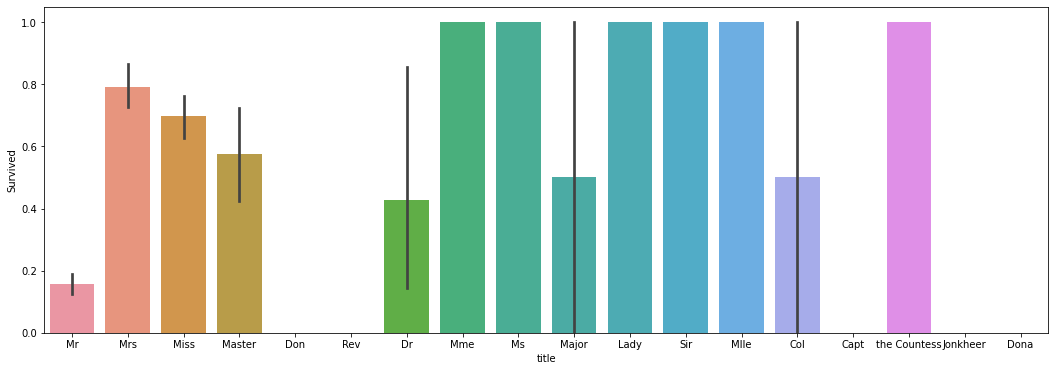

In [ ]:
#exploring the survivorship by titles 
fig, (axis1) = plt.subplots(1,figsize=(18,6))
sns.barplot(x="title", y="Survived", data=combined, ax=axis1);

In [ ]:
#replacing french titles
combined['title']=[re.sub('Mlle','Miss',x) for x in combined['title']]
combined['title']=[re.sub('Ms','Miss',x) for x in combined['title']]
combined['title']=[re.sub('Mme','Mrs',x) for x in combined['title']]
#replacing other titles
combined['title']=[re.sub('Dr','Leads',x) for x in combined['title']]
combined['title']=[re.sub('Major','Leads',x) for x in combined['title']]
combined['title']=[re.sub('Col','Leads',x) for x in combined['title']]
combined['title']=[re.sub('Dona','Rare',x) for x in combined['title']]
combined['title']=[re.sub('Don','Rare',x) for x in combined['title']]
combined['title']=[re.sub('Rev','Rare',x) for x in combined['title']]
combined['title']=[re.sub('Capt','Rare',x) for x in combined['title']]
combined['title']=[re.sub('Jonkheer','Rare',x) for x in combined['title']]
combined['title']=[re.sub('Lady','Elite',x) for x in combined['title']]
combined['title']=[re.sub('Sir','Elite',x) for x in combined['title']]
combined['title']=[re.sub('the Countess','Elite',x) for x in combined['title']]

In [ ]:
combined['title'] = combined['title'].map( {"Miss": 1, "Mrs": 2,"Master":3, "Mr": 5, "Leads": 4, "Rare": 3, "Elite": 0}) 

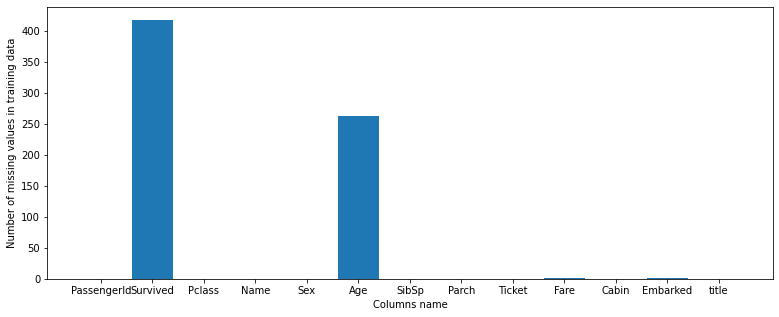

In [ ]:
#exploring missing data 
plt.figure(figsize = (13,5))
plt.bar(combined.columns, combined.isna().sum())
plt.xlabel("Columns name")
plt.ylabel("Number of missing values in training data")
plt.show()

In [ ]:
combined[combined['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,2


In [ ]:
combined['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

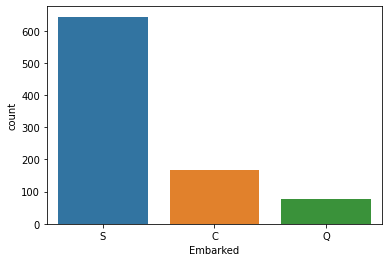

In [ ]:
sns.countplot('Embarked', data=train)

In [ ]:
combined['Embarked'][lambda x: x.isnull()]

61     NaN
829    NaN
Name: Embarked, dtype: object

In [ ]:
combined['Embarked'].fillna("S", inplace = True)
combined['Embarked']=combined['Embarked'].map({'S':1,'C':2,'Q':3})

In [ ]:
combined['FamSize']=combined['Parch']+combined['SibSp']+1

In [ ]:
combined['Alone'] = combined.SibSp + combined.Parch

combined.Alone = combined.Alone.apply(lambda x: 1 if x == 0 else 0)
combined.Alone=combined.Alone.astype('int64')

In [ ]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   object 
 1   Survived     891 non-null    object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   int64  
 12  title        1309 non-null   int64  
 13  FamSize      1309 non-null   int64  
 14  Alone        1309 non-null   int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 203.6+ KB


In [ ]:
combined.Alone.unique()

array([0, 1])

In [ ]:
from autoimpute.imputations import SingleImputer

In [ ]:
imp = SingleImputer(strategy={'Age':'pmm', 'Fare': 'pmm'},
                    predictors={'Age':['Sex','SibSp','Parch','title'], 'Fare':['Sex','SibSp','Parch','title']})
imputed=imp.fit_transform(combined)


/Users/keyrellousadib/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass fit_intercept=True, normalize=False, copy_X=True, n_jobs=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/keyrellousadib/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass fit_intercept=True, normalize=False, copy_X=True, n_jobs=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/keyrellousadib/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.
/Users/keyrellousadib/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.


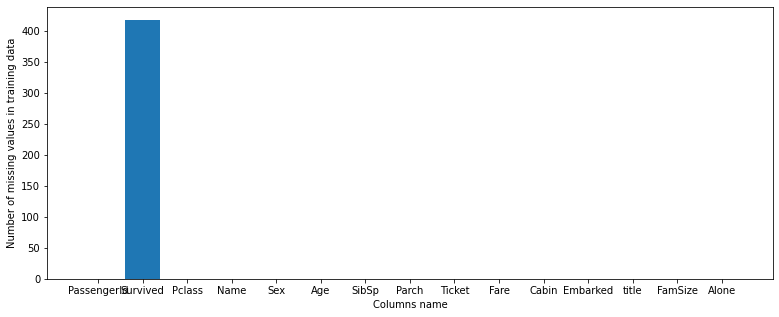

In [ ]:
plt.figure(figsize = (13,5))
plt.bar(imputed.columns, imputed.isna().sum())
plt.xlabel("Columns name")
plt.ylabel("Number of missing values in training data")
plt.show()

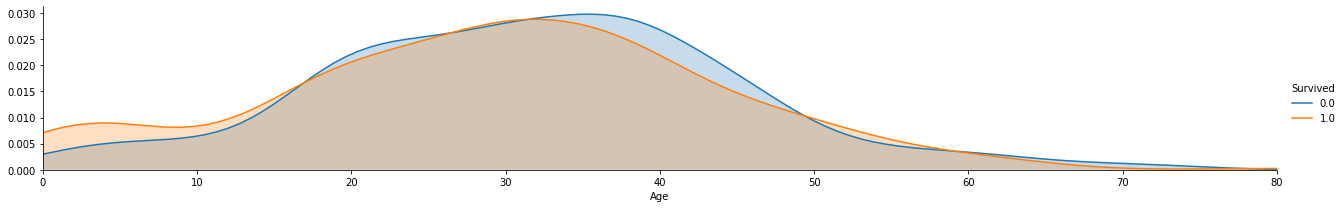

In [ ]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(imputed, hue = 'Survived', aspect=6 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train['Age'].max()))
a.add_legend()

In [ ]:
imputed.loc[ imputed['Age'] <= 14, 'Age']  = 0
imputed.loc[(imputed['Age'] > 14) & (imputed['Age'] <= 30), 'Age']        = 5
imputed.loc[(imputed['Age'] > 30) & (imputed['Age'] <= 40), 'Age']        = 1
imputed.loc[(imputed['Age'] > 40) & (imputed['Age'] <= 50), 'Age']        = 3
imputed.loc[(imputed['Age'] > 50) & (imputed['Age'] <= 60), 'Age']        = 2
imputed.loc[ imputed['Age'] > 60, 'Age']= 4

In [ ]:
imputed.Age.value_counts()

36.00    90
31.00    77
45.00    72
40.00    69
38.00    68
         ..
80.00     1
67.00     1
60.50     1
23.50     1
0.67      1
Name: Age, Length: 91, dtype: int64